<a href="https://colab.research.google.com/github/touchwolf/Big_dad/blob/master/California_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm, gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn import metrics# 指标includes score functions, performance metrics and pairwise metrics and distance computations.
from tensorflow.python.data import Dataset
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)#收到包含ERROR和FATAL的日志输出
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format#设定输出格式

In [0]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

In [0]:
california_housing_dataframe = california_housing_dataframe.reindex(
np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10316,-120.1,39.2,19.0,1746.0,306.0,251.0,104.0,4.8,146.9
12107,-121.4,37.7,40.0,859.0,196.0,427.0,176.0,3.6,110.4
3438,-117.9,33.9,28.0,1395.0,398.0,1220.0,362.0,3.3,193.8
3708,-117.9,34.1,34.0,1409.0,305.0,819.0,273.0,3.4,188.8
16790,-123.1,38.4,28.0,3297.0,676.0,923.0,373.0,3.9,232.6
...,...,...,...,...,...,...,...,...,...
4449,-118.0,33.8,32.0,3191.0,634.0,1718.0,611.0,4.2,216.6
11411,-121.2,38.7,27.0,5266.0,971.0,2432.0,948.0,3.9,133.0
8237,-118.4,34.0,39.0,3278.0,632.0,1321.0,617.0,6.3,465.7
12926,-121.8,36.6,33.0,1771.0,398.0,1037.0,388.0,2.8,161.8


In [0]:
california_housing_dataframe[["total_rooms"]]

,total_rooms
10316,1746.0
12107,859.0
3438,1395.0
3708,1409.0
16790,3297.0
...,...
4449,3191.0
11411,5266.0
8237,3278.0
12926,1771.0


## 检查数据

会输出各列的一些实用统计信息

样本数，均值，标准偏差，最大值，最小值，分位数

In [0]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [0]:
#多使用了中括号
my_feature = california_housing_dataframe["total_rooms"]

feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [0]:
targets = california_housing_dataframe["median_house_value"]

In [0]:
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

linear_regressor = tf.estimator.LinearRegressor(
  feature_columns = feature_columns,
  optimizer = my_optimizer
)

In [0]:
def my_input_fn(features, targets, batch_size = 1, shuffle = True, num_epochs = None):
  features = {key:np.array(value) for key,value in dict(features).items()}
  
  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(num_epochs)
  
  if shuffle:
    ds = ds.shuffle(buffer_size = 10000)
  
  features, labels = ds.make_one_shot_iterator().get_next()#one_shot迭代器，使用一次数据后即丢弃
  return features, labels

#不加入Lambda函数训练时会出错

In [0]:
_ = linear_regressor.train(
    input_fn = lambda: my_input_fn(my_feature, targets),
    steps = 100)

In [0]:
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs = 1, shuffle = False)

predictions = linear_regressor.predict(input_fn  = prediction_input_fn)

predictions = np.array([item['predictions'][0] for item in predictions])

mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean squared Error(on trainging data): %0.3f" % mean_squared_error)
print("Root Mean Error(on training data): % 0.3f" % root_mean_squared_error)

Mean squared Error(on trainging data): 55846.894
Root Mean Error(on training data):  236.319


In [0]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 236.319


In [0]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,1.3,207.3
std,1.1,116.0
min,0.0,15.0
25%,0.7,119.4
50%,1.1,180.4
75%,1.6,265.0
max,19.0,500.0


In [0]:
sample = california_housing_dataframe.sample(n =300)

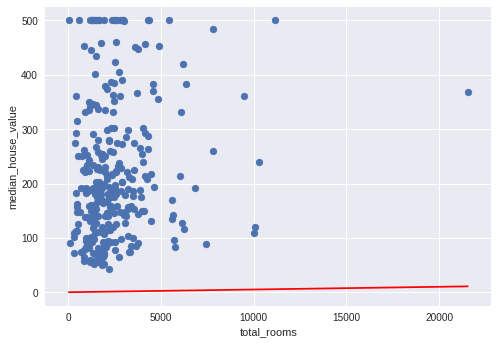

In [0]:
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

plt.plot([x_0,x_1], [y_0,y_1], c = 'r')

plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

plt.scatter(sample["total_rooms"], sample["median_house_value"])
plt.show()